In [123]:
!pip install tensorflow

In [125]:
! pip install segmentation-models

In [126]:
import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.utils import normalize
from tensorflow.keras.metrics import MeanIoU


In [127]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/dataset.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/RemyData")

In [129]:
def custom_round(value):
    if value < 64:
        return 0
    elif value < 192:
        return 128
    else:
        return 255
custom_round_vec = np.vectorize(custom_round)

dataset_dir = "/content/drive/MyDrive/RemyData/dataset/"

train_images_dir = os.path.join(dataset_dir, "train/images")
train_masks_dir = os.path.join(dataset_dir, "train/masks")
test_images_dir = os.path.join(dataset_dir, "test/images/")

#Resizing images
SIZE_X = 128
SIZE_Y = 128
n_classes = 3

# Create dictionaries to store mappings
train_images_dict = {}
train_masks_dict = {}

# Capture training image info and store in dictionaries
for img_path in glob.glob(os.path.join(train_images_dir, "*")):
    img_name = os.path.basename(img_path)
    mask_path = os.path.join(train_masks_dir, img_name)

    # Check if the corresponding mask exists
    if os.path.exists(mask_path):
        img = cv2.imread(img_path, 1)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images_dict[img_name] = img

        mask = cv2.imread(mask_path, 0)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)

        # Apply custom rounding function element-wise
        mask = custom_round_vec(mask)
        train_masks_dict[img_name] = mask.astype(np.uint8)

# Convert dictionaries to arrays for machine learning processing
train_images = np.array(list(train_images_dict.values()))
train_masks = np.array(list(train_masks_dict.values()))


test_images = []

for test_path in glob.glob(os.path.join(test_images_dir, "*.*")):
    test = cv2.imread(test_path, 0)
    test = cv2.resize(test, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
    test_images.append(test)

test_images = np.array(test_images)

print("Training Images Shape:", train_images.shape)
print("Training Masks Shape:", train_masks.shape)
print("Testing Images Shape:", test_images.shape)

Training Images Shape: (398, 128, 128, 3)
Training Masks Shape: (398, 128, 128)
Testing Images Shape: (102, 128, 128)


In [130]:
np.unique(train_masks)

array([  0, 128, 255], dtype=uint8)

In [138]:
from sklearn.preprocessing import LabelEncoder
unique_values = np.unique(train_masks)
print(unique_values)

n, h, w = train_masks.shape

# Print unique values in the original mask
print("Unique Values in Original Mask:", np.unique(train_masks))

# Flatten the 3D array
train_masks_flattened = train_masks.reshape(-1, 1)

# Print unique values in the flattened mask
print("Unique Values in Flattened Mask:", np.unique(train_masks_flattened))

# Apply LabelEncoder
labelencoder = LabelEncoder()
train_masks_encoded = labelencoder.fit_transform(train_masks_flattened)

# Print unique values in the encoded mask
print("Unique Values in Encoded Mask:", np.unique(train_masks_encoded))

# Reshape back to the original shape
train_masks_encoded_original_shape = train_masks_encoded.reshape(n, h, w)

# Display unique values in the reshaped and encoded mask
print("Unique Values in Encoded Original Shape Mask:", np.unique(train_masks_encoded_original_shape))


[  0 128 255]
Unique Values in Original Mask: [  0 128 255]
Unique Values in Flattened Mask: [  0 128 255]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Unique Values in Encoded Mask: [0 1 2]
Unique Values in Encoded Original Shape Mask: [0 1 2]


In [140]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
print(train_masks_input.shape)


(398, 128, 128, 1)


In [146]:
x_train.shape,x_val.shape,y_train.shape,y_val.shape

((358, 128, 128, 3), (40, 128, 128, 3), (358, 128, 128, 1), (40, 128, 128, 1))

In [147]:
import tensorflow as tf
import keras
import segmentation_models as sm

n_classes = 3
activation = 'softmax'

LR = 0.0001
optim = keras.optimizers.legacy.Adam(LR)
class_weights = np.array([0.25, 0.25, 0.25])

# Define dice_loss 
def custom_dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))
    return 1 - (numerator + 1) / (denominator + 1)

dice_loss = sm.losses.DiceLoss(custom_dice_loss, class_weights=class_weights)

# Define focal_loss using 
focal_loss = sm.losses.CategoricalFocalLoss()

# Combine losses 
total_loss = dice_loss + (1 * focal_loss)



metrics = [sm.metrics.IOUScore(threshold=0.5),
           sm.metrics.FScore(threshold=0.5) ]


In [148]:
###Model 1
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)


# preprocess input
X_train1 = preprocess_input1(x_train)
X_val1 = preprocess_input1(x_val)
# Ensure X_train1 and X_val1 are NumPy arrays
X_train1 = X_train1.numpy() if isinstance(X_train1, tf.Tensor) else X_train1
X_val1 = X_val1.numpy() if isinstance(X_val1, tf.Tensor) else X_val1

y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

# define model
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)
model1.compile(optim, loss=total_loss, metrics=metrics)

# print(model1.summary())
print(x_train.shape,y_train.shape)

history1=model1.fit(X_train1,
          y_train_cat,
          batch_size=8,
          epochs=50,
          verbose=1,
          validation_data=(X_val1, y_val_cat))


model1.save('res34_backbone_50epochs.hdf5')

(358, 128, 128, 3) (358, 128, 128, 1)
Epoch 1/50
45/45 [==============================] - 11s 111ms/step - loss: 0.9637 - iou_score: 0.2582 - f1-score: 0.3754 - val_loss: 1.0669 - val_iou_score: 0.0869 - val_f1-score: 0.1542
Epoch 2/50
45/45 [==============================] - 4s 87ms/step - loss: 0.9259 - iou_score: 0.5104 - f1-score: 0.6311 - val_loss: 0.9519 - val_iou_score: 0.2987 - val_f1-score: 0.4261
Epoch 3/50
45/45 [==============================] - 3s 76ms/step - loss: 0.9024 - iou_score: 0.6325 - f1-score: 0.7372 - val_loss: 0.9297 - val_iou_score: 0.4960 - val_f1-score: 0.6021
Epoch 4/50
45/45 [==============================] - 3s 67ms/step - loss: 0.8891 - iou_score: 0.6504 - f1-score: 0.7469 - val_loss: 0.8981 - val_iou_score: 0.6263 - val_f1-score: 0.7169
Epoch 5/50
45/45 [==============================] - 3s 70ms/step - loss: 0.8783 - iou_score: 0.6672 - f1-score: 0.7652 - val_loss: 0.8823 - val_iou_score: 0.6820 - val_f1-score: 0.7666
Epoch 6/50
45/45 [=================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


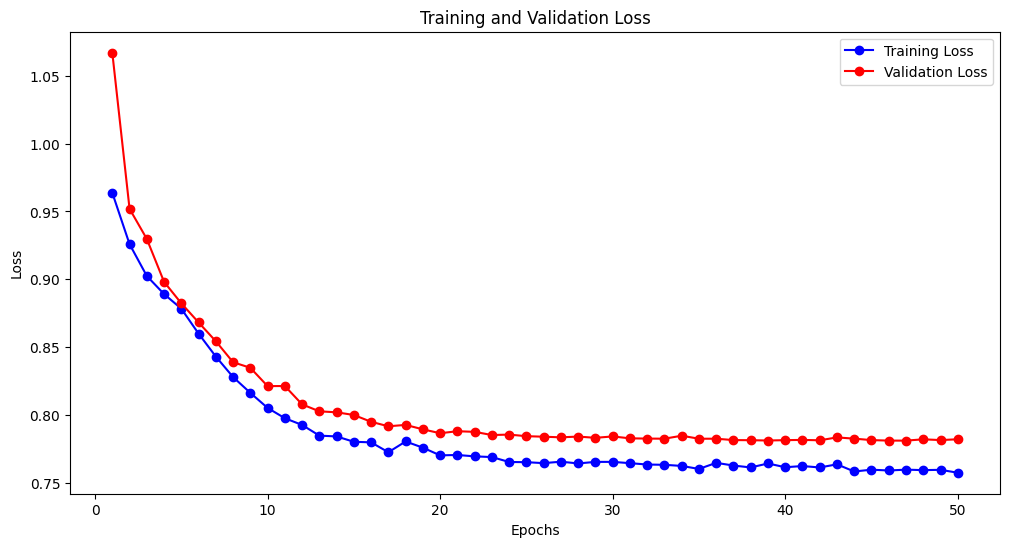

In [149]:
import matplotlib.pyplot as plt

# Training history
loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Plotting the training and validation loss
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [150]:
test_images.shape, y_train.shape

((102, 128, 128), (358, 128, 128, 1))

1/1 [==============================] - 1s 783ms/step
(128, 128, 3)
(128, 128)


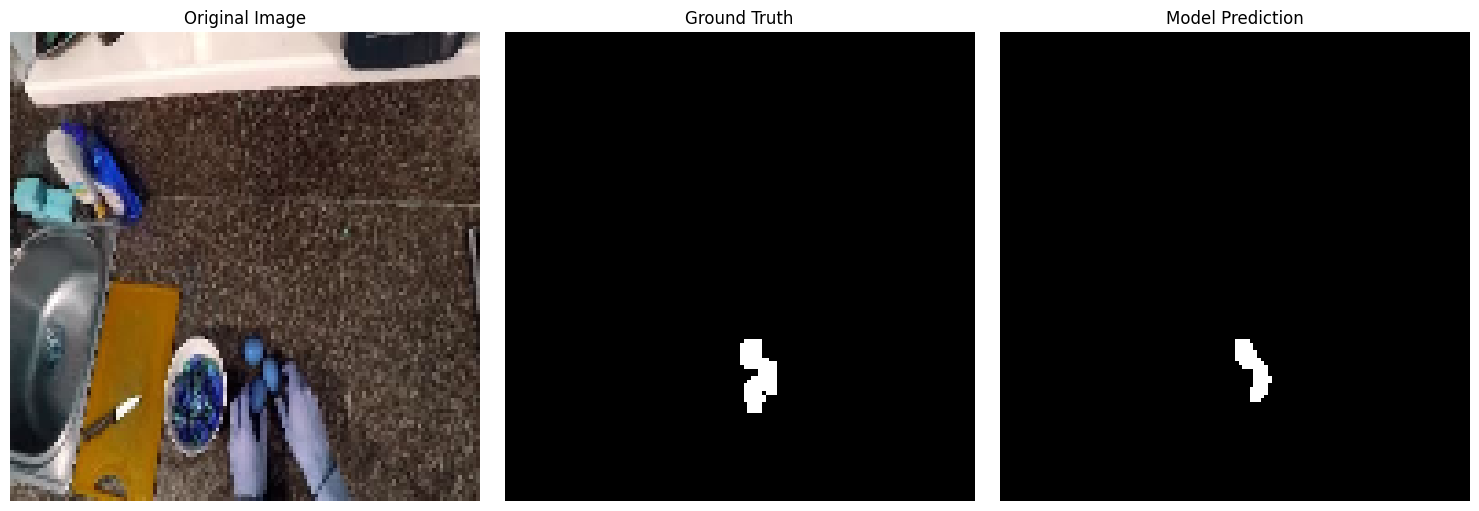

In [151]:
import numpy as np
import matplotlib.pyplot as plt

random_index = np.random.randint(len(X_val1))

# Get the corresponding ground truth for the selected validation sample
ground_truth = y_val[32]

# Get model prediction for the selected validation sample
prediction = model1.predict(np.expand_dims(X_val1[32], axis=0))[0]
print(prediction.shape)
predicted_class = np.argmax(prediction, axis=-1)
print(predicted_class.shape)


plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(X_val1[32])
plt.title('Original Image')
plt.axis('off')

# Ground Truth
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(ground_truth), cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

# Model Prediction
plt.subplot(1, 3, 3)
plt.imshow(predicted_class, cmap='gray')
plt.title('Model Prediction')
plt.axis('off')

plt.tight_layout()
plt.show()


In [153]:


# Model 2
BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

# preprocess input
X_train2 = preprocess_input2(x_train)
X_val2 = preprocess_input2(x_val)


# Ensure X_train2 and X_val2 are NumPy arrays
X_train2 = X_train2.numpy() if isinstance(X_train2, tf.Tensor) else X_train2
X_val2 = X_val2.numpy() if isinstance(X_val2, tf.Tensor) else X_val2

y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

# define model
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimizer, loss, and metrics
model2.compile(optim, total_loss, metrics=metrics)

print(model2.summary())

history2 = model2.fit(X_train2,
                      y_train_cat,
                      batch_size=8,
                      epochs=50,
                      verbose=1,
                      validation_data=(X_val2, y_val_cat))

model2.save('inceptionv3_backbone_50epochs.hdf5')


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, None, None, 32)       864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, None, None, 32)       96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, None, None, 32)       0         ['batch_normalization_18

ValueError: ignored

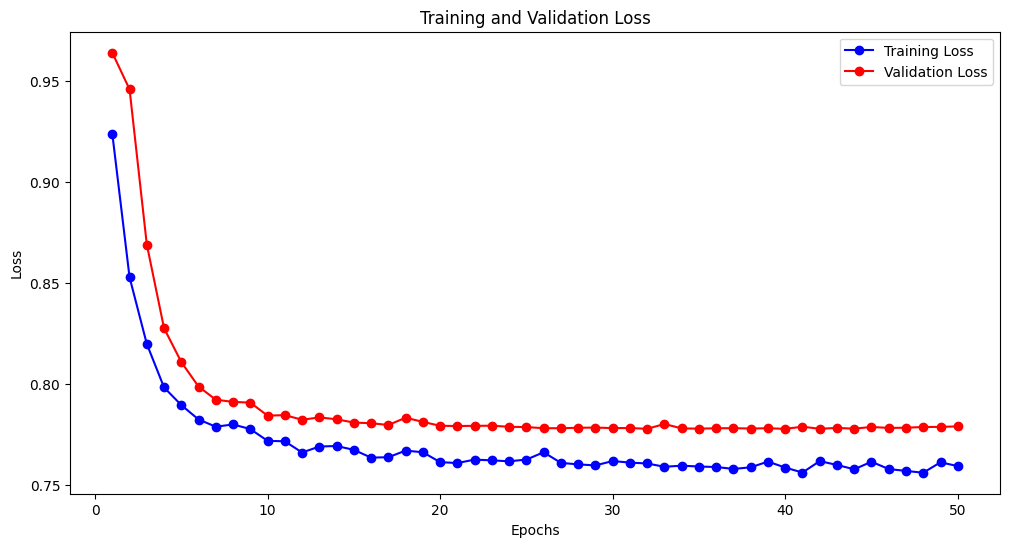

In [154]:
import matplotlib.pyplot as plt

# Training history
loss = history2.history['loss']
val_loss = history2.history['val_loss']

# Plotting the training and validation loss
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [155]:

# Model 3
BACKBONE3 = 'vgg16'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

# preprocess input
X_train3 = preprocess_input3(x_train)
X_val3 = preprocess_input3(x_val)

# Ensure X_train3 and X_val3 are NumPy arrays
X_train3 = X_train3.numpy() if isinstance(X_train3, tf.Tensor) else X_train3
X_val3 = X_val3.numpy() if isinstance(X_val3, tf.Tensor) else X_val3

y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

# define model
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimizer, loss, and metrics
model3.compile(optim, total_loss, metrics=metrics)

print(model3.summary())

history3 = model3.fit(X_train3,
                      y_train_cat,
                      batch_size=8,
                      epochs=50,
                      verbose=1,
                      validation_data=(X_val3, y_val_cat))

model3.save('vgg16_backbone_50epochs.hdf5')


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 64)       1792      ['input_6[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, None, None, 64)       36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, None, None, 64)       0         ['block1_conv2[0][0]']        
                                                                                            

ValueError: ignored

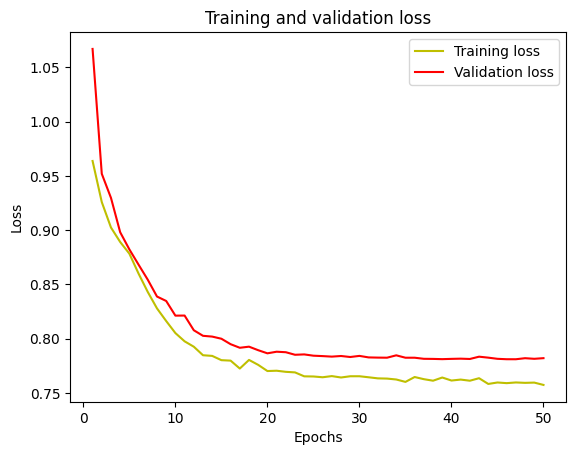

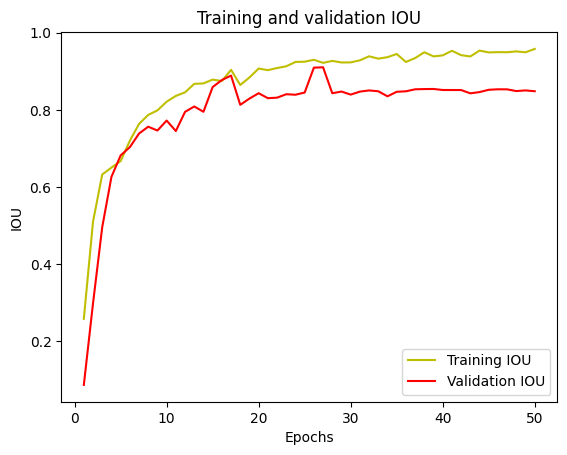

In [156]:
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [157]:
from keras.models import load_model

model1 = load_model('/content/res34_backbone_50epochs.hdf5', compile=False)
model2 = load_model('/content/inceptionv3_backbone_50epochs.hdf5', compile=False)
model3 = load_model('/content/vgg16_backbone_50epochs.hdf5', compile=False)

#Weighted average ensemble
models = [model1, model2, model3]

pred1 = model1.predict(X_val1)
pred2 = model2.predict(X_val2)
pred3 = model3.predict(X_val3)

preds=np.array([pred1, pred2, pred3])

#preds=np.array(preds)
weights = [0.3, 0.5, 0.2]

weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=3)

y_pred1_argmax=np.argmax(pred1, axis=3)
y_pred2_argmax=np.argmax(pred2, axis=3)
y_pred3_argmax=np.argmax(pred3, axis=3)


n_classes = 3
IOU1 = MeanIoU(num_classes=n_classes)
IOU2 = MeanIoU(num_classes=n_classes)
IOU3 = MeanIoU(num_classes=n_classes)
IOU_weighted = MeanIoU(num_classes=n_classes)

IOU1.update_state(y_val[:,:,:,0], y_pred1_argmax)
IOU2.update_state(y_val[:,:,:,0], y_pred2_argmax)
IOU3.update_state(y_val[:,:,:,0], y_pred3_argmax)
IOU_weighted.update_state(y_val[:,:,:,0], weighted_ensemble_prediction)


print('IOU Score for model1 = ', IOU1.result().numpy())
print('IOU Score for model2 = ', IOU2.result().numpy())
print('IOU Score for model3 = ', IOU3.result().numpy())
print('IOU Score for weighted average ensemble = ', IOU_weighted.result().numpy())

2/2 [==============================] - 1s 50ms/step


2/2 [==============================] - 2s 75ms/step


2/2 [==============================] - 0s 67ms/step
IOU Score for model1 =  0.91300875
IOU Score for model2 =  0.9312613
IOU Score for model3 =  0.92821056
IOU Score for weighted average ensemble =  0.9356877


In [158]:
import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 4):
    for w2 in range(0,4):
        for w3 in range(0,4):
            wts = [w1/10.,w2/10.,w3/10.]

            IOU_wted = MeanIoU(num_classes=n_classes)
            wted_preds = np.tensordot(preds, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds, axis=3)
            IOU_wted.update_state(y_val[:,:,:,0], wted_ensemble_pred)
            print("Now predciting for weights :", w1/10., w2/10., w3/10., " : IOU = ", IOU_wted.result().numpy())
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
                                         'wt3':wts[2], 'IOU': IOU_wted.result().numpy()}, index=[0]), ignore_index=True)

max_iou_row = df.iloc[df['IOU'].idxmax()]
print("Max IOU of ", max_iou_row[3], " obained with w1=", max_iou_row[0],
      " w2=", max_iou_row[1], " and w3=", max_iou_row[2])

Now predciting for weights : 0.0 0.0 0.0  : IOU =  0.316214
Now predciting for weights : 0.0 0.0 0.1  : IOU =  0.92821056
Now predciting for weights : 0.0 0.0 0.2  : IOU =  0.92821056
Now predciting for weights : 0.0 0.0 0.3  : IOU =  0.92821056


<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],


Now predciting for weights : 0.0 0.1 0.0  : IOU =  0.9312613
Now predciting for weights : 0.0 0.1 0.1  : IOU =  0.9345439
Now predciting for weights : 0.0 0.1 0.2  : IOU =  0.93113947
Now predciting for weights : 0.0 0.1 0.3  : IOU =  0.9303756


<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],


Now predciting for weights : 0.0 0.2 0.0  : IOU =  0.9312613
Now predciting for weights : 0.0 0.2 0.1  : IOU =  0.9339762
Now predciting for weights : 0.0 0.2 0.2  : IOU =  0.9345439
Now predciting for weights : 0.0 0.2 0.3  : IOU =  0.93205714


<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],


Now predciting for weights : 0.0 0.3 0.0  : IOU =  0.9312613
Now predciting for weights : 0.0 0.3 0.1  : IOU =  0.933363
Now predciting for weights : 0.0 0.3 0.2  : IOU =  0.9346865
Now predciting for weights : 0.0 0.3 0.3  : IOU =  0.9345439


<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],


Now predciting for weights : 0.1 0.0 0.0  : IOU =  0.91300875
Now predciting for weights : 0.1 0.0 0.1  : IOU =  0.9273665
Now predciting for weights : 0.1 0.0 0.2  : IOU =  0.93074226
Now predciting for weights : 0.1 0.0 0.3  : IOU =  0.92994565


<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],


Now predciting for weights : 0.1 0.1 0.0  : IOU =  0.9309418
Now predciting for weights : 0.1 0.1 0.1  : IOU =  0.9329157
Now predciting for weights : 0.1 0.1 0.2  : IOU =  0.9318995
Now predciting for weights : 0.1 0.1 0.3  : IOU =  0.93190455


<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],


Now predciting for weights : 0.1 0.2 0.0  : IOU =  0.932396
Now predciting for weights : 0.1 0.2 0.1  : IOU =  0.9360688
Now predciting for weights : 0.1 0.2 0.2  : IOU =  0.9339053
Now predciting for weights : 0.1 0.2 0.3  : IOU =  0.9322865


<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],


Now predciting for weights : 0.1 0.3 0.0  : IOU =  0.93214226
Now predciting for weights : 0.1 0.3 0.1  : IOU =  0.9342602
Now predciting for weights : 0.1 0.3 0.2  : IOU =  0.9363869
Now predciting for weights : 0.1 0.3 0.3  : IOU =  0.9339504


<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],


Now predciting for weights : 0.2 0.0 0.0  : IOU =  0.91300875
Now predciting for weights : 0.2 0.0 0.1  : IOU =  0.9180353
Now predciting for weights : 0.2 0.0 0.2  : IOU =  0.9273665
Now predciting for weights : 0.2 0.0 0.3  : IOU =  0.9307211


<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],


Now predciting for weights : 0.2 0.1 0.0  : IOU =  0.9193025
Now predciting for weights : 0.2 0.1 0.1  : IOU =  0.9277153
Now predciting for weights : 0.2 0.1 0.2  : IOU =  0.9321363
Now predciting for weights : 0.2 0.1 0.3  : IOU =  0.93145365


<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],


Now predciting for weights : 0.2 0.2 0.0  : IOU =  0.9309418
Now predciting for weights : 0.2 0.2 0.1  : IOU =  0.9322702
Now predciting for weights : 0.2 0.2 0.2  : IOU =  0.9329157
Now predciting for weights : 0.2 0.2 0.3  : IOU =  0.93337506


<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],


Now predciting for weights : 0.2 0.3 0.0  : IOU =  0.932206
Now predciting for weights : 0.2 0.3 0.1  : IOU =  0.93525845
Now predciting for weights : 0.2 0.3 0.2  : IOU =  0.9337216
Now predciting for weights : 0.2 0.3 0.3  : IOU =  0.9336849


<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],


Now predciting for weights : 0.3 0.0 0.0  : IOU =  0.91300875
Now predciting for weights : 0.3 0.0 0.1  : IOU =  0.91634876
Now predciting for weights : 0.3 0.0 0.2  : IOU =  0.9201596
Now predciting for weights : 0.3 0.0 0.3  : IOU =  0.9273665


<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],


Now predciting for weights : 0.3 0.1 0.0  : IOU =  0.9168546
Now predciting for weights : 0.3 0.1 0.1  : IOU =  0.9205335
Now predciting for weights : 0.3 0.1 0.2  : IOU =  0.92746216
Now predciting for weights : 0.3 0.1 0.3  : IOU =  0.9321658


<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],


Now predciting for weights : 0.3 0.2 0.0  : IOU =  0.9211836
Now predciting for weights : 0.3 0.2 0.1  : IOU =  0.9283476
Now predciting for weights : 0.3 0.2 0.2  : IOU =  0.93130094
Now predciting for weights : 0.3 0.2 0.3  : IOU =  0.9321892


<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],


Now predciting for weights : 0.3 0.3 0.0  : IOU =  0.9309418
Now predciting for weights : 0.3 0.3 0.1  : IOU =  0.93214065
Now predciting for weights : 0.3 0.3 0.2  : IOU =  0.9322683
Now predciting for weights : 0.3 0.3 0.3  : IOU =  0.9329157
Max IOU of  0.9363868832588196  obained with w1= 0.1  w2= 0.3  and w3= 0.2


<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],
<ipython-input-158-d276aa9dd5ab>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],


In [159]:
opt_weights = [max_iou_row[0], max_iou_row[1], max_iou_row[2]]
opt_weighted_preds = np.tensordot(preds, opt_weights, axes=((0),(0)))
opt_weighted_ensemble_prediction = np.argmax(opt_weighted_preds, axis=3)

1/1 [==============================] - 0s 26ms/step


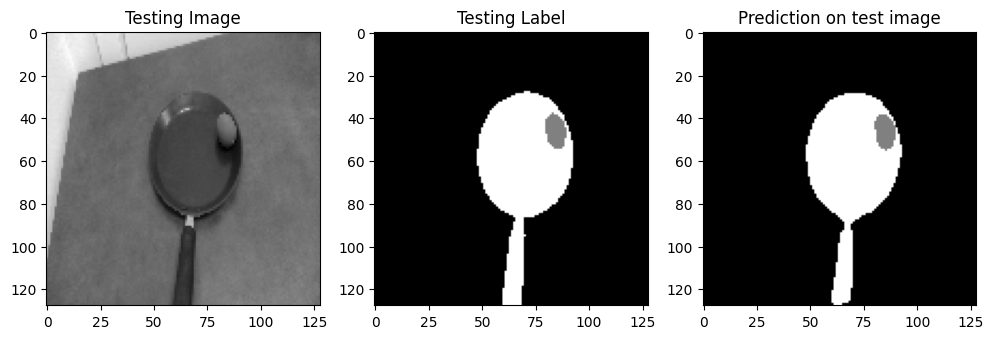

In [160]:
import random
test_img_number = random.randint(0, len(x_val))
test_img = x_val[test_img_number]
ground_truth=y_val[test_img_number]
test_img_norm=test_img[:,:,:]
test_img_input=np.expand_dims(test_img_norm, 0)

#Weighted average ensemble
models = [model1, model2, model3]

test_img_input1 = preprocess_input1(test_img_input)
test_img_input2 = preprocess_input2(test_img_input)
test_img_input3 = preprocess_input3(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_pred2 = model2.predict(test_img_input2)
test_pred3 = model3.predict(test_img_input3)

test_preds=np.array([test_pred1, test_pred2, test_pred3])

weighted_test_preds = np.tensordot(test_preds, opt_weights, axes=((0),(0)))
weighted_ensemble_test_prediction = np.argmax(weighted_test_preds, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(weighted_ensemble_test_prediction, cmap='gray')
plt.show()

(102, 128, 128)
(102, 128, 128, 3)
4/4 [==============================] - 0s 55ms/step


ValueError: ignored

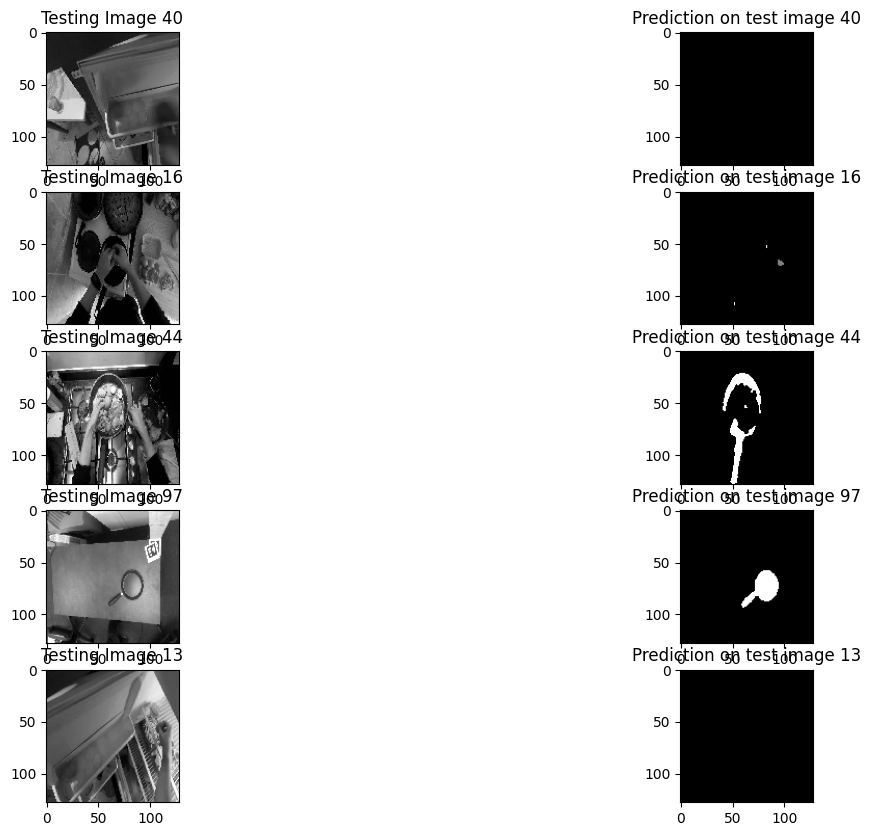

In [162]:
import random
import matplotlib.pyplot as plt


print(test_images.shape)
testing_data_reshaped = test_images[..., np.newaxis]

# Repeat along the channel dimension to make it compatible with the model input shape
testing_data_reshaped = np.repeat(testing_data_reshaped, 3, axis=-1)
print(testing_data_reshaped.shape)



# Weighted average ensemble
models = [model1, model2, model3]

test_img_input1 = preprocess_input1(testing_data_reshaped)
test_img_input2 = preprocess_input2(testing_data_reshaped)
test_img_input3 = preprocess_input3(testing_data_reshaped)

test_pred1 = model1.predict(test_img_input1)
test_pred2 = model2.predict(test_img_input2)
test_pred3 = model3.predict(test_img_input3)

test_preds = np.array([test_pred1, test_pred2, test_pred3])

weighted_test_preds = np.tensordot(test_preds, opt_weights, axes=((0), (0)))
weighted_ensemble_test_prediction = np.argmax(weighted_test_preds, axis=-1)

random_indices = random.sample(range(testing_data_reshaped.shape[0]), 102)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices, 1):
    plt.subplot(5, 2, i * 2 - 1)
    plt.title(f'Testing Image {idx}')
    plt.imshow(testing_data_reshaped[idx, :, :, 0], cmap='gray')

    plt.subplot(5, 2, i * 2)
    plt.title(f'Prediction on test image {idx}')
    plt.imshow(weighted_ensemble_test_prediction[idx], cmap='gray')

plt.tight_layout()
plt.show()


In [163]:
import random
import os
import matplotlib.pyplot as plt

print(test_images.shape)
testing_data_reshaped = test_images[..., np.newaxis]

testing_data_reshaped = np.repeat(testing_data_reshaped, 3, axis=-1)
print(testing_data_reshaped.shape)

save_folder = 'prediction_images1'
os.makedirs(save_folder, exist_ok=True)

# Weighted average ensemble
models = [model1, model2, model3]

test_img_input1 = preprocess_input1(testing_data_reshaped)
test_img_input2 = preprocess_input2(testing_data_reshaped)
test_img_input3 = preprocess_input3(testing_data_reshaped)

test_pred1 = model1.predict(test_img_input1)
test_pred2 = model2.predict(test_img_input2)
test_pred3 = model3.predict(test_img_input3)

test_preds = np.array([test_pred1, test_pred2, test_pred3])

weighted_test_preds = np.tensordot(test_preds, opt_weights, axes=((0), (0)))
weighted_ensemble_test_prediction = np.argmax(weighted_test_preds, axis=-1)

random_indices = random.sample(range(testing_data_reshaped.shape[0]), 102)

# Save all predictions
for i, idx in enumerate(random_indices, 1):
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title(f'Testing Image {idx}')
    plt.imshow(testing_data_reshaped[idx, :, :, 0], cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title(f'Prediction on test image {idx}')
    plt.imshow(weighted_ensemble_test_prediction[idx], cmap='gray')

    plt.tight_layout()

    # Save the figure
    save_path = os.path.join(save_folder, f'prediction_{idx}.png')
    plt.savefig(save_path)
    plt.close()

print(f'Predictions saved in {save_folder}')


(102, 128, 128)
(102, 128, 128, 3)
4/4 [==============================] - 0s 56ms/step
Predictions saved in prediction_images1


In [164]:
import shutil

folder_to_zip = 'prediction_images1'
shutil.make_archive(folder_to_zip, 'zip', folder_to_zip)


'/content/prediction_images1.zip'